## Processing a large .xlsx file locally

In [1]:
# Install necessary packages withing the current environment

import sys

# Commented out in order to test quickly, remove comments when first run

# !{sys.executable} -m pip install --upgrade pandas
# !{sys.executable} -m pip install --upgrade openpyxl
# !{sys.executable} -m pip install --upgrade nltk
# !{sys.executable} -m nltk.downloader stopwords
# !{sys.executable} -m nltk.downloader wordnet
# !{sys.executable} -m nltk.downloader vader_lexicon
# !{sys.executable} -m pip install matplotlib

In [2]:
import pandas as pd

import re
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib
import matplotlib.pyplot as plt

# Set default max column length to be displayed in pandas DataFrame
pd.set_option("display.max_colwidth", 200)
# %matplotlib inline
# Set default style/theme of matplotlib graphs
matplotlib.style.use("seaborn-darkgrid")
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

data_file = "data/data_no-duplicates.xlsx"

In [3]:
# Check initial data and data types
df = pd.read_excel(data_file, engine='openpyxl')
df.sample(4)
print('Types of data:\n\n', df.dtypes)

Types of data:

 id_str                  float64
from_user                object
text                     object
created_at               object
time                     object
favorite_count          float64
retweet_count           float64
retweeted_status         object
lang                     object
user_location            object
user_followers_count    float64
user_friends_count      float64
entities_str             object
dtype: object


## Initial data file reading to Pandas DataFrame object

Read XLSX file:
 - Convert data types
 - Parse dates
 - Drop unnecessary columns

In [4]:
# Read XLSX file:
#  - Convert data types
#  - Parse dates
#  - Drop unnecessary columns

data_types = {
    "id_str": str,
    "from_user": str,
    "text": str,
    #'created_at': datetime,
    #'time': datetime,
    "favorite_count": "Int32",
    "retweet_count": "Int32",
    "retweeted_status": str,
    "lang": str,
    "user_location": str,
    "user_followers_count": "Int32",
    "user_friends_count": "Int32",
    "entities_str": str,
}

mydateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M:%S")

df = pd.read_excel(
    data_file, parse_dates=["time"], date_parser=mydateparser, dtype=data_types, index_col=None,                 engine="openpyxl"
)

df = df.drop(columns=["created_at", "entities_str", "from_user"])

df = df.rename(columns={"time": "created_at"})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187153 entries, 0 to 187152
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id_str                187152 non-null  object        
 1   text                  187152 non-null  object        
 2   created_at            187152 non-null  datetime64[ns]
 3   favorite_count        16736 non-null   Int32         
 4   retweet_count         163056 non-null  Int32         
 5   retweeted_status      153353 non-null  object        
 6   lang                  187152 non-null  object        
 7   user_location         98369 non-null   object        
 8   user_followers_count  187152 non-null  Int32         
 9   user_friends_count    186711 non-null  Int32         
dtypes: Int32(4), datetime64[ns](1), object(5)
memory usage: 12.1+ MB
None


In [5]:
# Data sample
display(df.sample(4))

,id_str,text,created_at,favorite_count,retweet_count,retweeted_status,lang,user_location,user_followers_count,user_friends_count
170821,1313755929909906944,"#Aliyev is responsible for targeting civilians, schools, homes....for stealing childhood from the children of #Artsakh! But anyway, the international terrorists are powerless against the unbreakab...",2020-10-07 09:19:56,<NA>,<NA>,NaN,en,NaN,30,72
136466,1314169438770541056,RT @Kornelij: #Turkey Deploys Syrian terrorists to #Azerbaijan in the war against #Karabakh and #Armenia \n\n#StopTurkey #SanctionTurkey #ArmeniaAgainstTerrorism https://t.co/0thQD0h2Ui,2020-10-08 12:43:04,<NA>,202,"{extended_entities={media=[Ljava.lang.Object;@ce5682e}, metadata={result_type=recent, iso_language_code=en}, in_reply_to_status_id_str=null, in_reply_to_status_id=null, created_at=Thu Oct 08 11:36...",en,NaN,76,113
71000,1314857417931469056,"RT @Karabakh_MoD: ‼️ Ignoring the humanitarian truce announced on October 10 at 12:00, #Azerbaijan’i units launched an attack on the Karahambeyli area at 12:05. \n\n#Artsakh Defense Army Units are...",2020-10-10 10:16:51,<NA>,240,"{metadata={result_type=recent, iso_language_code=en}, in_reply_to_status_id_str=null, in_reply_to_status_id=null, created_at=Sat Oct 10 08:46:35 +0000 2020, in_reply_to_user_id_str=null, source=<a...",en,NaN,77,81
32379,1315239400524014080,RT @GeorgeMelikyan: #Turkey has problems w #Greece 🇬🇷\n#Turkey has problems w #Cyprus 🇨🇾\n#Turkey has problems w #Syria 🇸🇾\n#Turkey has problems w #iraq 🇮🇶\n#Turkey has problems w #Libia 🇱🇾\n#Turk...,2020-10-11 11:34:43,<NA>,251,"{metadata={result_type=recent, iso_language_code=en}, in_reply_to_status_id_str=null, in_reply_to_status_id=null, created_at=Sat Oct 10 20:34:57 +0000 2020, in_reply_to_user_id_str=null, source=<a...",en,NaN,42,179


### Remove rows with retweets

In [6]:
# Remove rows with retweets, drop 'retweeted_status' column

# WORKS too: df = df[df['retweeted_status'].isna()]

df.drop(df[df["retweeted_status"].notna()].index, inplace=True)
df.drop(columns="retweeted_status", inplace=True)
df.info

<bound method DataFrame.info of                      id_str  \
4       1315546055187013888   
7       1315546031317291008   
22      1315545898856914944   
42      1315545805277733120   
46      1315545778765529088   
...                     ...   
187130  1313559800928768000   
187131  1313559800500956928   
187137  1313559770876521984   
187138  1313559770805142016   
187152  1313559695131542016   

                                                                                                                                                                                                           text  \
4       Тысячи жителей армянской общины Лос-Анджелеса проводят акцию протеста перед зданием консульства Турции\n#Armenia #ArtsakhStrong #Artsakh #nagornokarabakh #StopAzerbaijaniAggression \n\nhttps://t.c...   
7       Supporting Armenia means\nTo be on the side of  Nationalists with monoethnic country, Armenian Terrorism, Deathes in Karabakh and on border with Azerbaijan, Armenian

### Some info on user languages

In [7]:
# Records per language

rec_per_lang = df["lang"].value_counts()
print(rec_per_lang.head(10))

en     22777
und     6156
fr      1138
tr       993
es       572
hy       485
ru       385
de       348
in       208
it       141
Name: lang, dtype: int64


## User location

In [8]:
print("Info on user location:\n\n", df["user_location"].describe())

df["user_location"].value_counts().head(25)

Info on user location:

 count       20033
unique       2047
top       Armenia
freq         3187
Name: user_location, dtype: object


Armenia              3187
Azerbaijan           1463
Los Angeles, CA      1330
Yerevan, Armenia     1031
United States         442
City of Angels        394
Yerevan               381
Baku, Azerbaijan      355
Paris, France         220
France                193
Los Angeles           185
Armenia, Yerevan      179
Armenia 🇦🇲            177
Baku                  174
California, USA       171
New York, NY          166
Toronto, Ontario      109
London, England       102
Córdoba Argentina     101
Glendale, CA           98
İstanbul, Türkiye      96
Washington, DC         95
Türkiye                89
Paris                  85
München                81
Name: user_location, dtype: int64

### Correct the most frequent differently marked locations
E.g. 'Yerevan, Armenia' -> 'Armenia', 'Los Angeles, CA' -> 'United States'

In [9]:
# Correct the most frequent locations

# Dic structure: {'original text': 'to_be text'}
locations_dic = {
    "Los Angeles, CA": "USA",
    "City of Angels": "USA",
    "Yerevan, Armenia": "Armenia",
    "Baku, Azerbaijan": "Azerbaijan",
    "Armenia 🇦🇲": "Armenia",
    "Los Angeles": "USA",
    "New York, NY": "USA",
    "California, USA": "USA",
    "Armenia, Yerevan": "Armenia",
    "Paris, France": "France",
    "Baku": "Azerbaijan",
    "Toronto, Ontario": "Canada",
    "Washington, DC": "USA",
    "Glendale, CA": "USA",
    "London, England": "UK",
    "New York, USA": "USA",
    "Boston, MA": "USA",
    "United States": "USA",
    "Yerevan": "Armenia",
    "Azerbaijan, Baku": "Azerbaijan",
    "Córdoba Argentina": "Argentina",
    "İstanbul, Türkiye": "Turkey",
    "Türkiye": "Turkey",
}


def replace_location(location: str, locations_dic=locations_dic):
    return locations_dic[location] if location in locations_dic else location


df["user_location"] = df["user_location"].apply(lambda x: replace_location(x))

In [10]:
df["user_location"].value_counts().head(10)

Armenia       4955
USA           3072
Azerbaijan    2069
France         413
Turkey         232
Canada         187
UK             129
Argentina      110
Paris           85
München         81
Name: user_location, dtype: int64

### Locations per user language

[ISO 639-1 language codes](https://www.loc.gov/standards/iso639-2/php/code_list.php):
- `hy` - Armenian
- `und` - undefined
- `in` - Indonesian

In [11]:
loc_per_lang = df.groupby(df["lang"])["user_location"].describe()
# sort by count descending
# "hy" = Armenian
loc_per_lang.sort_values(by="count", ascending=False).head(10)

,count,unique,top,freq
lang,,,,
en,13406,1493,Armenia,3777
und,3423,463,USA,1047
fr,839,165,France,172
tr,639,163,Azerbaijan,214
es,436,53,Argentina,101
hy,352,46,Armenia,277
ru,255,48,Armenia,107
de,195,58,München,79
it,96,34,Italia,28


### Remove all records with non-English language

In [12]:
# Remove rows except with lang='en'

df.drop(df[df["lang"] != "en"].index, inplace=True)

print("Data rows left after non-English rows removed:", len(df))

# Sort ascending by created_at
df.sort_values(by="created_at", inplace=True)
# Set new index
df.index = range(0, len(df))

Data rows left after non-English rows removed: 22777


### Locations for English tweets

In [13]:
df["user_location"].value_counts().head(10)

Armenia                                   3777
USA                                       1936
Azerbaijan                                1283
France                                     205
Canada                                     145
UK                                         116
Turkey                                     100
Lebanon                                     52
Freedom=The Right to SPEAK Peacefully.      48
Stepanakert, Artsakh Republic               46
Name: user_location, dtype: int64

## Functions for tweet pre-processing

In [14]:
# Function to preprocess a tweet

# To lower case
def lower_case(txt: list) -> list:
    return [word.lower() for word in txt]


# Remove username
def remove_username(txt: list) -> list:
    return [re.sub(r"@(?i)[a-z0-9_]+", "", word, flags=re.MULTILINE) for word in txt]


# Remove retweet tags
def remove_tags(txt: list) -> list:
    return [re.sub(r"RT^@(?i)[a-z0-9_]+", "", word, flags=re.MULTILINE) for word in txt]


# Remove Urls
def remove_url(txt: list) -> list:
    return [
        re.sub(
            r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S",
            "",
            word,
            flags=re.MULTILINE,
        )
        for word in txt
    ]


# Remove stopwords
def remove_stopwords(txt: list, stop_words: list) -> list:
    return [word for word in txt if not word.lower() in stop_words]


# Remove punctuation.
# N.B.: As a side effect, also removes hashtags.
def remove_punctuations(txt: list) -> list:
    return [word for word in txt if word.isalpha()]


# Lemmatize
def lemmatize(txt: list, lemmatizer=WordNetLemmatizer()) -> list:
    return [lemmatizer.lemmatize(word) for word in txt]


# test_tweet = (df['text'].sample(1)).to_numpy()
# print(test_tweet, type(test_tweet))

In [15]:
# Tweet preprocessing

custom_stopwords = "Artsakh Karabakh Armenia Azerbaijan".lower().split()
stop_words = stopwords.words("english") + custom_stopwords

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()


def tweet_preprocessor(
    tweet: str,
    tweet_tokenizer=TweetTokenizer(),
    tweet_lemmatizer=WordNetLemmatizer(),
    stop_words: list = list(stopwords.words("english")),
) -> list:
    """
    Input: tweet text with optional parameters
    Output: tokenized, cleaned and lemmatized list of words
    """

    text = tweet_tokenizer.tokenize(tweet)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_username(text)
    text = remove_url(text)
    text = remove_stopwords(text, stop_words)
    text = lemmatize(text)
    text = remove_punctuations(text)

    text = ", ".join(word for word in text)

    return text


df["text_cleaned"] = df["text"].apply(lambda x: tweet_preprocessor(x, stop_words=stop_words))

---

# Sentiment analysis

**N.B.** Both do _not_ need the text to be tokenized or lemmatized beforehand.

- using **VADER**

    - _VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media._

    - The 'compound' score is a very useful metric in case we want a single measure of sentiment. Typical threshold values are the following:

        - positive: compound score>=0.05
        - neutral: compound score between -0.05 and 0.05
        - negative: compound score<=-0.05

    - Notice that VADER:

        - It is case sensitive. The sentence This is great has a different score than the sentence This is GREAT.
        - Punctuation matters. The exclamation marks for example have a positive score
        - The emojis have also a score and actually very strong sentiments. Try the <3, :) , :p and :(
        - Words after @ and # have a neutral score.
        
        Therefore there's no need to clean the text first.

    - see [https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/](https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)

    OR
    
- using **TextBlob**
    - see [https://textblob.readthedocs.io/en/dev/](https://textblob.readthedocs.io/en/dev/)
    
> _The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective._

> _You can use other tokenizers, such as those provided by NLTK, by passing them into the TextBlob constructor then accessing the tokens property._

```python
        testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!", , tokenizer=TweetTokenizer())
        testimonial.sentiment
        $ Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)
        testimonial.sentiment.polarity
        $ 0.39166666666666666
```


## VADER analysis

In [16]:
# VADER analysis

# sentiment score analyzer using VADER
s_analyzer = SentimentIntensityAnalyzer()

# using original text
df["vader"] = df["text"].apply(lambda x: s_analyzer.polarity_scores(x)["compound"])

# using cleaned text
df["vader_clean"] = df["text_cleaned"].apply(
    lambda x: s_analyzer.polarity_scores(x)["compound"]
)

### Check whether VADER gives similar results on original and cleaned twitter text

In [17]:
# Check whether VADER gives similar results on original and cleaned twitter text

df["vader_same"] = df["vader"] * df["vader_clean"] >= 0

print("vader_same results:")
df["vader_same"].value_counts()

vader_same results:


True     21547
False     1230
Name: vader_same, dtype: int64

In [18]:
# Comparison of VADER score of original and cleaned tweet text

display(
    df[["vader", "vader_clean", "vader_same", "text", "text_cleaned"]].sample(
        n=5, random_state=2
    )
)

,vader,vader_clean,vader_same,text,text_cleaned
10724,-0.4215,-0.4215,True,#StopAliyev because he broke a ceasefire agreement to bomb Armenian civilians in #Artsakh during the #COVID19 pandemic,"broke, ceasefire, agreement, bomb, armenian, civilian, pandemic"
21226,-0.6124,-0.6124,True,"1200-year-old #Ganja, #Azerbaijan’s 2nd largest city. 100km far from #Karabakh. Entire residential neighborhood wiped out by #missiles launched by #Armenia. At least 9 #Azerbaijani civilians kille...","largest, city, far, entire, residential, neighborhood, wiped, launched, least, civilian, killed, wounded, incl"
632,-0.4226,0.1027,False,@AFP Since when historically Inhabited territories are called “Occupied”? In the door of collapse of USSR people in #Artsakh like people in #Azerbaijan claimed for independence. This is internatio...,"since, historically, inhabited, territory, called, occupied, door, collapse, ussr, people, like, people, claimed, independence, internationally, acknowledged, right, internationally, accepted, she..."
14651,0.1860,0.0000,True,"#Azerbaijan’s ruling elite ran a secret $2.8 billion slush fund for two years to pay off #European politicians and pay for luxury purchases, an investigation has shown. @JosepBorrellF\n@MarinaKalj...","ruling, elite, ran, secret, billion, slush, fund, two, year, pay, politician, pay, luxury, purchase, investigation, shown, fyi"
10631,-0.8126,-0.8225,True,Everyone was quick to yell at people to #StayHome because #COVID19 “MAY” be deadly. The attacks of #Azerbaijan on the civilian population of #Artsakh ARE deadly. Armenians are being killed. SPEAK...,"everyone, quick, yell, people, may, deadly, attack, civilian, population, deadly, armenian, killed, speak"


### We have 1230 out of 21547 records (5.7%) with mismatching VADER results:

- It proves the point, that cleaning the tweet text is not necessary while using VADER in most of the cases.

In [19]:
# Drop unnecessary columns 'vader_clean', 'vader_same'
# Rename column 'vader' -> 'vader_value'

df.drop(columns=["vader_clean", "vader_same"], inplace=True)

df.rename(columns={"vader": "vader_value"}, inplace=True)

display(df.columns)

Index(['id_str', 'text', 'created_at', 'favorite_count', 'retweet_count',
       'lang', 'user_location', 'user_followers_count', 'user_friends_count',
       'text_cleaned', 'vader_value'],
      dtype='object')

### Recode 'vader_value' column (representing VADER 'compound score') to 'vader' column

Treshold values and mapping are the following:

- positive: compound score>=0.1
- neutral: compound score between -0.1 and 0.1
- negative: compound score<=-0.1

In [20]:
# Recoding vader to positive/ negative/ neutral


def recode_vader(score, pos=0.1, neg=-0.1):
    if score >= 0.1:
        return "positive"
    elif score <= -0.1:
        return "negative"
    else:
        return "neutral"


df["vader"] = df["vader_value"].apply(lambda x: recode_vader(x))

In [21]:
display(df[["vader_value", "vader", "text", "text_cleaned"]].sample(n=5, random_state=0))

,vader_value,vader,text,text_cleaned
11061,0.0000,neutral,Bro this guys still barking #artsakhstrong #defendarmenia #stopaliyev #stoperdogan #stopazerbaijaniaggression #stopazeriaggression #peaceforarmenians #peaceforarmenia #peaceforartsakh #karabakh #Հ...,"bro, guy, still, barking"
8510,-0.7269,negative,"#StopAzerbaijaniAggression Today Azerbaijan has used Turkish missiles to bomb a cathedral in Shushi, #Artsakh and destroyed a historic and sacred landmark. Injuring foreign journalists. #SanctionT...","today, used, turkish, missile, bomb, cathedral, shushi, destroyed, historic, sacred, landmark, injuring, foreign, journalist"
12807,-0.2292,negative,"Be aware, if You will not stop it later you will regret and will be to late...\n#ՀԱՂԹԵԼՈԻԵՆՔ #StopErdogan #StopAzerbaijaniAggression #ArmeniaStrong #Artsakh https://t.co/6adzazEUqB","aware, stop, later, regret, late"
18472,-0.9381,negative,"Tonight at 2 AM, Armenian side launched missile attack on #Ganja, #Azerbaijan. \n\nAs a result of the attack on civilian infrastructure, a residential building completely destroyed, at least 3 civ...","tonight, armenian, side, launched, missile, attack, result, attack, civilian, infrastructure, residential, building, completely, destroyed, least, civilian, died, injured"
14292,0.4809,positive,"Its probably too soon to say something about the substance of negotiations that took 11 hours behind the doors, but I know one thing for sure Azerbaijani Nation will never be the same &amp; will n...","probably, soon, say, something, substance, negotiation, took, hour, behind, door, know, one, thing, sure, azerbaijani, nation, never, never, accept, half, baked, solution"


## Statistics related to sentiments (positive / negative / neutral)

0. Sentiments count
1. Sentiments related to user location
2. Sentiments related to the length of the tweet
3. Sentiments related to friends count
4. Favourites related to sentiments - no useful data
5. Retweet count related to sentiments
6. User followers count related to sentiments
7. Sentiments dynamic by observation day


### 0. Sentiments count

<AxesSubplot:title={'center':'Sentiments count, total'}>

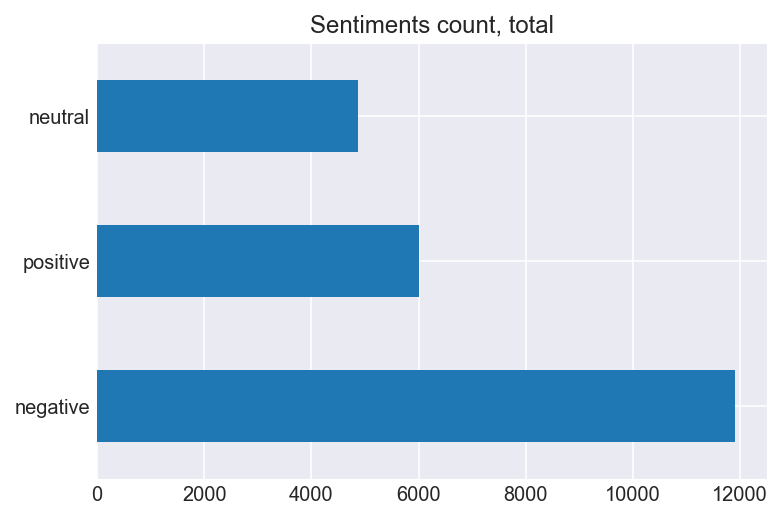

In [22]:
df.vader.value_counts().plot(kind="barh", title="Sentiments count, total")

### 1. Sentiments related to user location

              count unique       top  freq
user_location                             
Armenia        3777      3  negative  2032
USA            1936      3  negative   993
Azerbaijan     1283      3  negative   670
France          205      3  negative   103
Canada          145      3  negative    74
UK              116      3  negative    68
Turkey          100      3  negative    47
Lebanon          52      3  negative    29


<AxesSubplot:title={'center':'Sentiments count (total) per top user locations'}, xlabel='User location'>

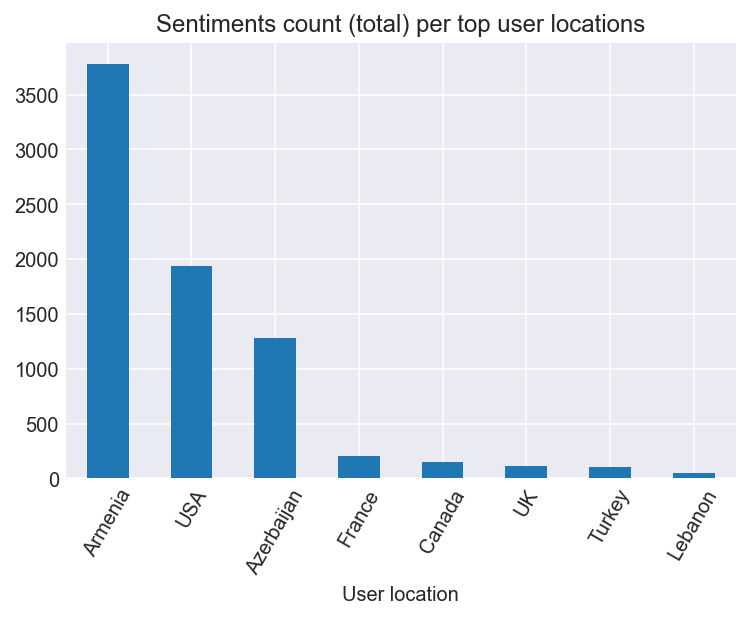

In [23]:
# Sentiments related to user location

loc_per_lang = df.groupby(df["user_location"])["vader"].describe()

# sort by count descending
p = loc_per_lang.sort_values(by="count", ascending=False).head(8)
print(p)

# p = loc_per_lang.sort_values(by='count', ascending=False).head(8)
p["count"].plot(
    kind="bar",
    title="Sentiments count (total) per top user locations",
    xlabel="User location",
    rot=60,
)
# df.groupby(df['user_location'])['vader'].count().sort_values(ascending=False).head(10)

### 2. Sentiments related to the length of the tweet

In [24]:
# Sentiments related to the length of the tweet

df["tweet_length"] = df["text"].apply(lambda x: len(x))

print("Sentiments related to the length of the tweet (mean):")

df.groupby("vader")["tweet_length"].mean().round(0)

# print('Mean values:\n', df.groupby('vader')['tweet_length'].mean().round(0))
# print('\nMedian values:\n', df.groupby('vader')['tweet_length'].median().round(0))
# print('\nNumber of observations:\n', df.groupby('vader')['tweet_length'].count())

Sentiments related to the length of the tweet (mean):


vader
negative    242.0
neutral     188.0
positive    222.0
Name: tweet_length, dtype: float64

#### --> Generally (mean value) negative tweets are longer (242 char), positive tweets are shorter (222 char), and neutral ones are the shortest (188 char).

### 3. Sentiments related to friends count

In [25]:
print("Sentiments related to friends count (mean):")

df.groupby(df["vader"])["user_friends_count"].mean().round(0)

Sentiments related to friends count (mean):


vader
negative    480.0
neutral     588.0
positive    571.0
Name: user_friends_count, dtype: float64

### 4. Favourites related to sentiments
-- no useful info as very low numbers (mean = 7).

In [26]:
df["favorite_count"].describe()

count    11725.000000
mean         7.003753
std         29.026018
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1000.000000
Name: favorite_count, dtype: float64

### 5. Retweet count related to sentiments

In [27]:
print("Sentiments related to retweet count:")

df.groupby(df["vader"])["retweet_count"].count()


Sentiments related to retweet count:


vader
negative    3891
neutral     1580
positive    1927
Name: retweet_count, dtype: int64

### 6. User followers count related to sentiments

In [28]:
print("User followers count related to sentiments:")

df.groupby(df["vader"])["user_followers_count"].count()

User followers count related to sentiments:


vader
negative    11902
neutral      4865
positive     6010
Name: user_followers_count, dtype: int64

### 7. Sentiments dynamic by observation day

In [29]:
df["created_at"]
# eg. df.groupby(df['lang'])['user_location'].describe()

print(df.groupby(df["created_at"].dt.day_name())["vader"].value_counts())

print("\nPositive sentiments:")
print(df[df["vader"] == "positive"].groupby(df["created_at"].dt.day_name())["vader"].count())

print("\nNegative sentiments:")
print(df[df["vader"] == "negative"].groupby(df["created_at"].dt.day_name())["vader"].count())


created_at  vader   
Friday      negative    2103
            positive    1285
            neutral     1044
Monday      negative     346
            positive     324
            neutral      167
Saturday    negative    2273
            positive    1035
            neutral      866
Sunday      negative    2049
            positive     948
            neutral      684
Thursday    negative    2362
            neutral     1031
            positive     994
Tuesday     negative     426
            positive     242
            neutral      199
Wednesday   negative    2343
            positive    1182
            neutral      874
Name: vader, dtype: int64

Positive sentiments:
created_at
Friday       1285
Monday        324
Saturday     1035
Sunday        948
Thursday      994
Tuesday       242
Wednesday    1182
Name: vader, dtype: int64

Negative sentiments:
created_at
Friday       2103
Monday        346
Saturday     2273
Sunday       2049
Thursday     2362
Tuesday       426
Wednesday    2343


In [30]:
# creating dummies in order to split positive and negative sentiments per day

dum = df[["vader", "created_at"]]
dum = pd.get_dummies(dum)
dum["created_at"] = dum["created_at"].apply(lambda x: x.day_name())
display(dum)
# dum2 = dum.groupby(df['created_at'])['vader_positive', 'vader_negative', 'vader_neutral']
# dum2.plot()
# dum.plot(x="created_at", y=["vader_negative"])

,created_at,vader_negative,vader_neutral,vader_positive
0,Tuesday,1,0,0
1,Tuesday,0,1,0
2,Tuesday,1,0,0
3,Tuesday,1,0,0
4,Tuesday,1,0,0
...,...,...,...,...
22772,Monday,0,1,0
22773,Monday,1,0,0
22774,Monday,1,0,0
22775,Monday,1,0,0


In [31]:
dum.index = range(0, len(dum))
dum.index
dumpl = pd.DataFrame(
    dum.groupby(["created_at"])["vader_positive"].sum(), index=dum["created_at"].unique()
)
dumpl["vader_negative"] = dum.groupby(["created_at"])["vader_negative"].sum()
dumpl["vader_neutral"] = dum.groupby(["created_at"])["vader_neutral"].sum()
display(dumpl)

,vader_positive,vader_negative,vader_neutral
Tuesday,242.0,426.0,199.0
Wednesday,1182.0,2343.0,874.0
Thursday,994.0,2362.0,1031.0
Friday,1285.0,2103.0,1044.0
Saturday,1035.0,2273.0,866.0
Sunday,948.0,2049.0,684.0
Monday,324.0,346.0,167.0


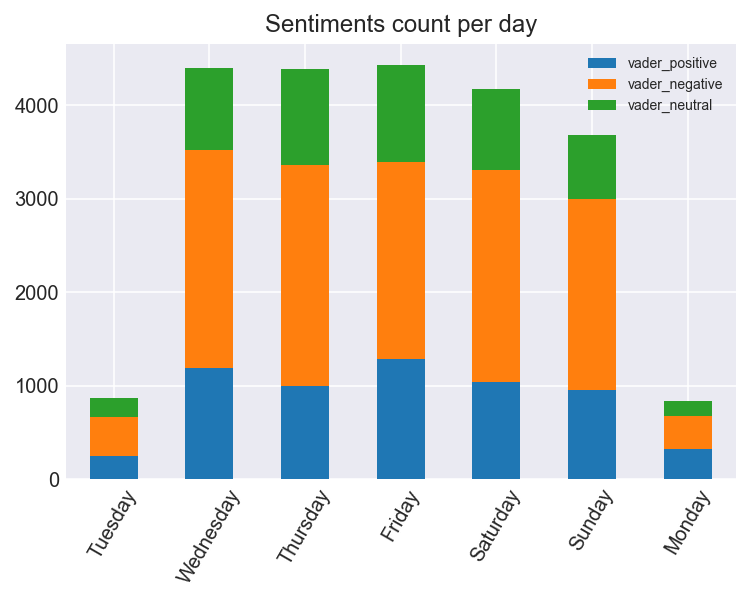

In [32]:
dumpl.plot(kind="bar", title="Sentiments count per day", rot=60, stacked=True).legend(
    loc="upper right", ncol=1, prop={"size": 7}
)

## Optionally - write resulting DataFrame back to new .xlsx file

In [33]:
# write dataframe to excel file with sheet name

output_filename = "data/data_processed.xlsx"
sheetname = "data"

with pd.ExcelWriter(output_filename) as writer:
    df.to_excel(writer, sheet_name=sheetname, index=False, engine="openpyxl")

from os import stat

print(f"Resulting file:\n {output_filename}\n {round(os.stat(output_filename).st_size/(1024*1024), 2)}MB")

Resulting file:
 data/data_processed.xlsx
 4.19MB


# Wordcloud
Using [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud)

In [34]:
# Wordcloud

# image mask must be black on white background
mask_image_path = "twitter-logo-mask.png"
# resulting file name
wordcloud_file_path = "wordcloud.png"

# uncomment next line if running for the first time
# !{sys.executable} -m pip install wordcloud
from os import path
import numpy as np
from wordcloud import WordCloud
from PIL import Image

In [35]:
# read the mask image

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# image_mask = np.array(plt.imread(mask_image_path))
image_mask = np.array(Image.open(path.join(d, mask_image_path)))

# use the same stopwords as for VADER analysis
stopwords = stop_words + ["armenian"]

In [36]:
# prepare text for wordcloud
# using cleaned tweets' text

text = "".join(list(df["text_cleaned"].to_numpy()))

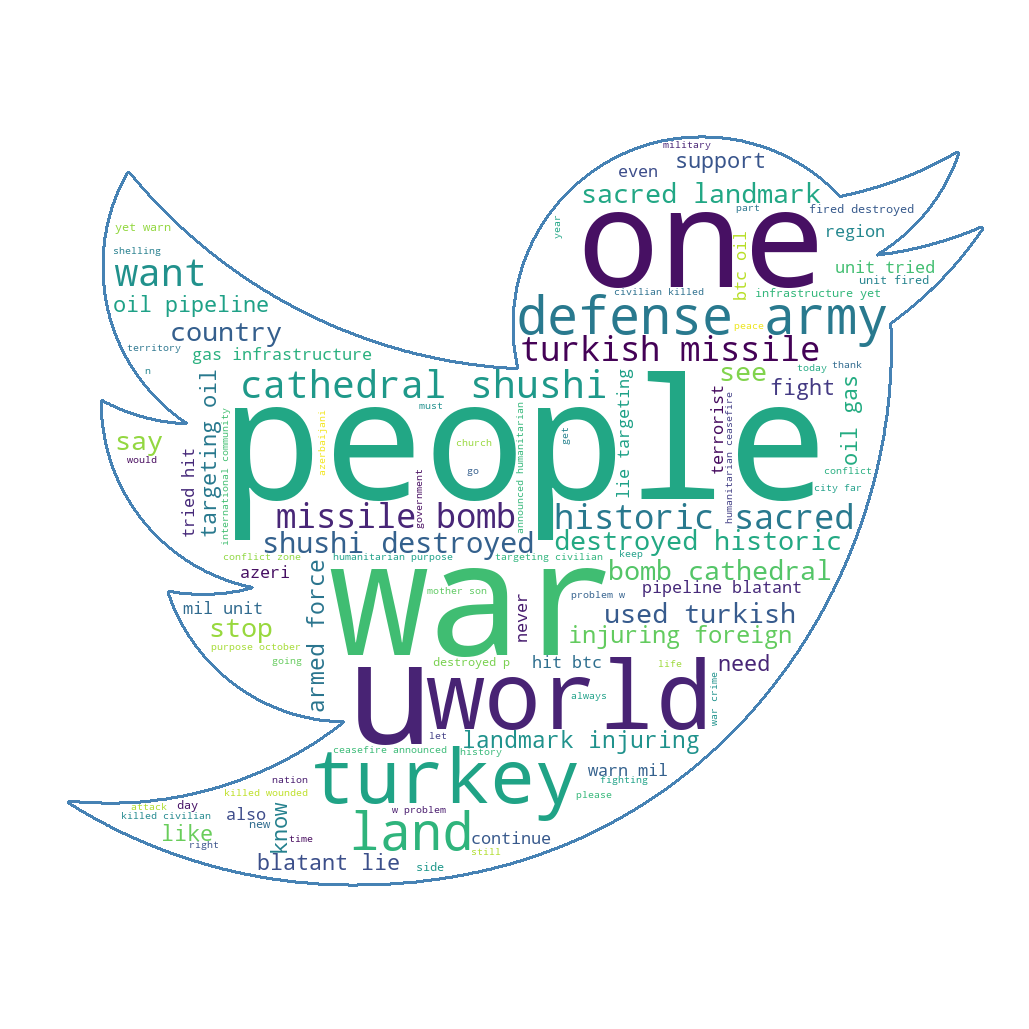

In [37]:
# Generate wordcloud, save picture and display it

wc = WordCloud(
    background_color="white",
    max_words=300,
    mask=image_mask,
    stopwords=stopwords,
    contour_width=3,
    contour_color="steelblue",
    min_font_size=8,
)

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, wordcloud_file_path))

# show resulting image
display(Image.open(wordcloud_file_path))